Predict the value on a single part chart image using fastai

In [1]:
from typing import *
from concurrent.futures.process import ProcessPoolExecutor
import logging
import collections
from datetime import datetime, timedelta
from pathlib import Path
from importlib import reload
import itertools
import functools
import subprocess
import io
import os
import gc
import re
import sys
import time
import logging
import pickle
import json
import random
import string
import numpy as np
import scipy
from scipy import stats
from tqdm.auto import tqdm
import pandas as pd
from sklearn import model_selection, metrics, preprocessing, ensemble, neighbors, cluster, decomposition, inspection, \
    linear_model
import matplotlib.pyplot as plt
from functools import partial
import torch
import torch.nn as nn
from core import *

from fastai.vision.all import *
from slibtk import slibtk

logging.basicConfig(**log_config)
logger = logging.getLogger(__name__)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
tqdm.pandas()

In [3]:
def test_img() -> Path:
    value = random.random()
    fig, ax = plt.subplots()
    ax.bar(['value'], value)
    ax.set_ylim([0, 1])
    img_path = Paths.RAW / f'{value}.png'
    plt.savefig(img_path.as_posix())
#     logger.info(f'saving: {img_path}')
    return img_path


def save_img(ser: pd.Series) -> Path:
    fig, ax = plt.subplots()
    ax.bar(['value'], ser['value'])
    ax.set_ylim([0, 1])
    img_path = Paths.RAW / f'{int(ser["index"])}_{ser["value"]}.png'
    plt.savefig(img_path.as_posix())
#     logger.info(f'saving: {img_path}')
    plt.close()
    return img_path


@slibtk.with_cache(Paths.CACHES)
def make_charts(n: int = 5000) -> pd.DataFrame:
    df = pd.Series(np.random.rand(n)).to_frame('value').reset_index()
    df['img_path'] = df.progress_apply(save_img, axis=1)
    return df


def rm_charts() -> None:
    for p in Paths.RAW.glob('*.png'): p.unlink()


def parse_label(fname: str):
    return float(re.search('\d+_(0\.\d+)\.png', fname).group(1))

In [4]:
df = make_charts()

08-05-2021 18:34:19 INFO     [slibtk.py:605] reading pickle: /home/jupyter/img_factory/data/caches/make_charts.pickle
08-05-2021 18:34:19 INFO     [slibtk.py:66] read_pickle: output=      index   value                                                         img_path
0         0 0.61976       /home/jupyter/img_factory/data/raw/0_0.619755410238265.png
1         1 0.44196     /home/jupyter/img_factory/data/raw/1_0.44195992078457746.png
2         2 0.30394      
08-05-2021 18:34:19 INFO     [slibtk.py:231] loaded return from cache: make_charts


In [6]:
df.head(10)

,index,value,img_path
0,0,0.61976,/home/jupyter/img_factory/data/raw/0_0.619755410238265.png
1,1,0.44196,/home/jupyter/img_factory/data/raw/1_0.44195992078457746.png
2,2,0.30394,/home/jupyter/img_factory/data/raw/2_0.3039361081601598.png
3,3,0.91162,/home/jupyter/img_factory/data/raw/3_0.9116163511450728.png
4,4,0.61212,/home/jupyter/img_factory/data/raw/4_0.6121159359611676.png
5,5,0.69984,/home/jupyter/img_factory/data/raw/5_0.6998392812485402.png
6,6,0.72179,/home/jupyter/img_factory/data/raw/6_0.7217916156210856.png
7,7,0.10288,/home/jupyter/img_factory/data/raw/7_0.10287934916529862.png
8,8,0.65188,/home/jupyter/img_factory/data/raw/8_0.651881008539692.png
9,9,0.79251,/home/jupyter/img_factory/data/raw/9_0.79251020035231.png


In [7]:
path = next(Paths.RAW.iterdir())
im = Image.open(path)
im.to_thumb(128, 128)
plt.show()

fns = get_image_files(Paths.RAW)

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('img_path'),
    get_y=ColReader('value'),
    splitter=RandomSplitter(),
    item_tfms=Resize(128, ResizeMethod.Squish)
).dataloaders(df)

learn = cnn_learner(dls, resnet34, metrics=[rmse, mae])

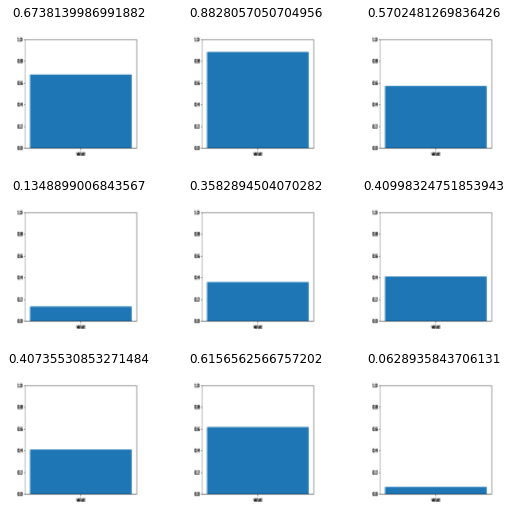

In [9]:
dls.show_batch()

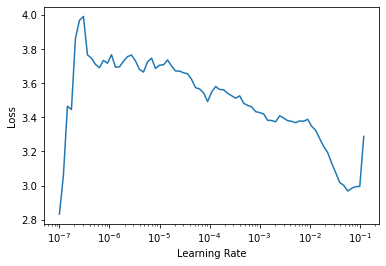

In [10]:
lr_min, lr_steep = learn.lr_find()

In [12]:
learn.fine_tune(60)

epoch,train_loss,valid_loss,_rmse,mae,time
0,2.780421,0.957675,0.978609,0.723532,00:08


epoch,train_loss,valid_loss,_rmse,mae,time
0,1.386309,0.377936,0.614765,0.468824,00:10
1,1.188716,0.147838,0.384498,0.267954,00:09
2,0.975710,0.114261,0.338025,0.242049,00:09
3,0.836963,0.094892,0.308045,0.226364,00:10
4,0.692335,0.043587,0.208776,0.139884,00:10
5,0.558400,0.036577,0.191251,0.141051,00:10
6,0.420361,0.016083,0.126819,0.101306,00:10
7,0.302324,0.045993,0.214460,0.165605,00:10
8,0.219730,0.012817,0.113213,0.077881,00:10
9,0.144636,0.015471,0.124381,0.108935,00:10


In [28]:
path_model = slibtk.next_fname(Paths.MODELS / 'img_regressor.fastai')
learn.save(path_model)

Path('/home/jupyter/img_factory/models/img_regressor_00.fastai.pth')

In [43]:
path_img = test_img()
print(learn.predict(path_img))
path_img

In [45]:
# dbs = dbs.new(item_tfms=Resize(128, ResizeMethod.Squish))

# Classifciation Binary Version

In [25]:
df['target'] = np.where(df['value'] > 0.5, 'above', 'below')

In [26]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('img_path'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(),
    item_tfms=Resize(224, ResizeMethod.Squish)
).dataloaders(df)

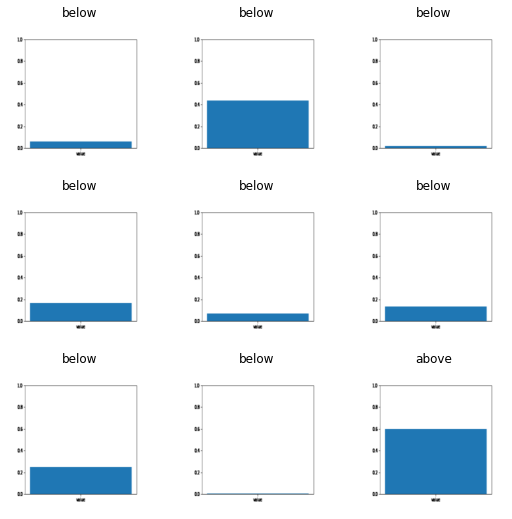

In [27]:
dls.show_batch()

In [28]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, RocAucBinary()])

In [29]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.080484,0.004095,0.001000,0.999998,00:18


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.023354,0.009555,0.001000,0.999978,00:23


In [30]:
interp = ClassificationInterpretation.from_learner(learn)

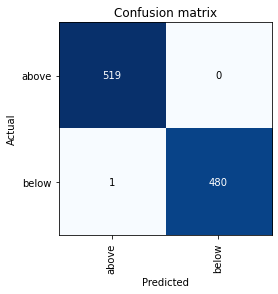

In [31]:
interp.plot_confusion_matrix()

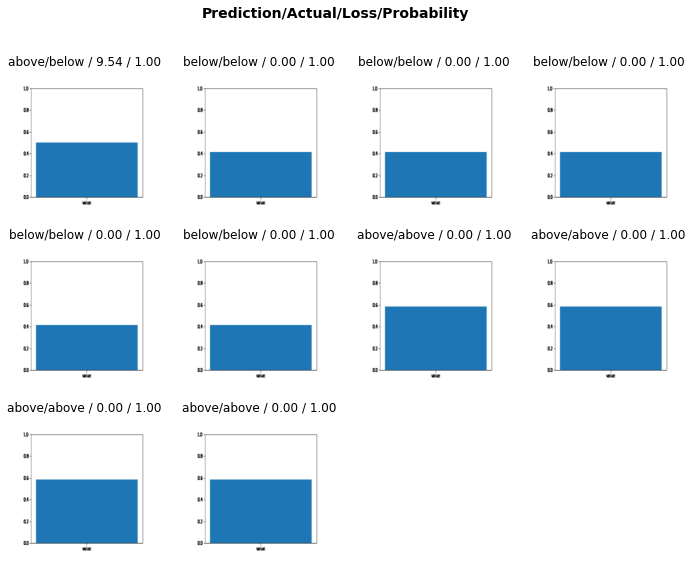

In [32]:
interp.plot_top_losses(10)

In [33]:
learn.dls.vocab

['above', 'below']

('below', tensor(1), tensor([1.3761e-06, 1.0000e+00]))


Path('/home/jupyter/img_factory/data/raw/0.2566326653629578.png')

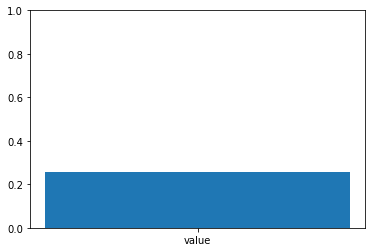

In [34]:
path_img = test_img()
print(learn.predict(path_img))
path_img

# Classification Multiclass

In [22]:
df['class'] = 'cls_' + pd.qcut(df['value'], 5, labels=False, duplicates='drop').astype(str)

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('img_path'),
    get_y=ColReader('class'),
    splitter=RandomSplitter(),
    item_tfms=Resize(224, ResizeMethod.Squish)
).dataloaders(df)

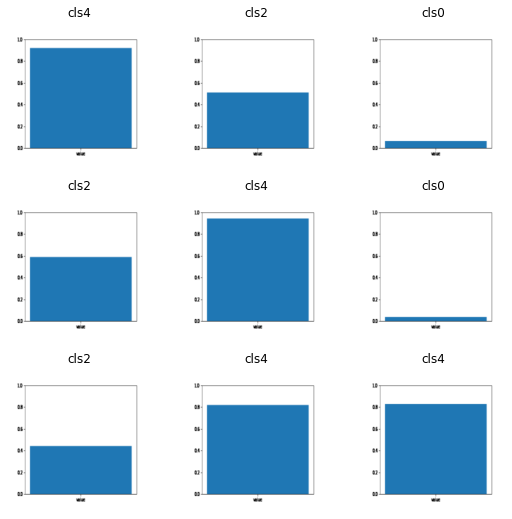

In [24]:
dls.show_batch()

In [25]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, RocAuc()])

In [26]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.288982,0.033539,0.994000,0.999838,00:18


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.093379,0.016630,0.994000,0.999959,00:23


In [27]:
interp = ClassificationInterpretation.from_learner(learn)

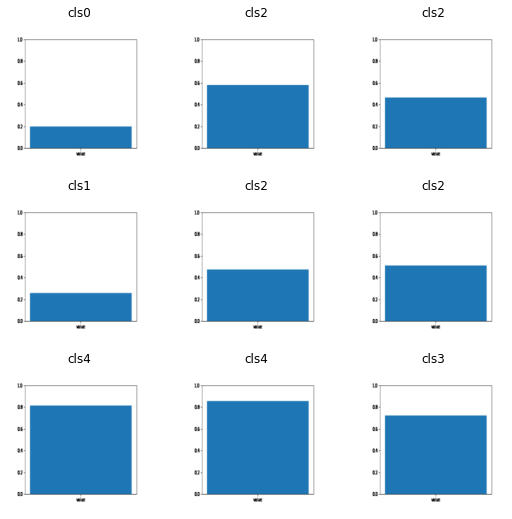

In [28]:
learn.dls.valid.show_batch()

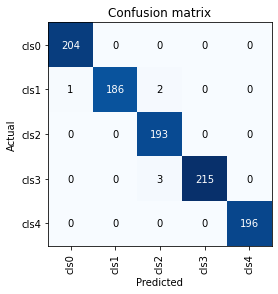

In [30]:
interp.plot_confusion_matrix()

In [32]:
interp.most_confused()

[('cls3', 'cls2', 3), ('cls1', 'cls2', 2), ('cls1', 'cls0', 1)]

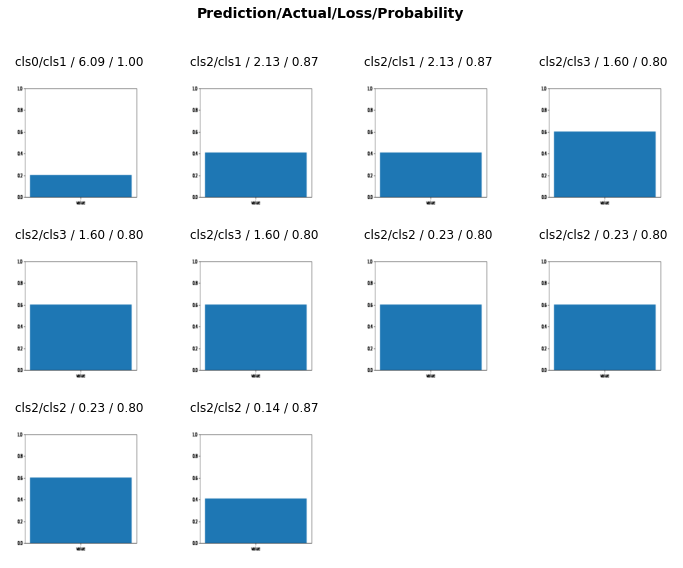

In [31]:
interp.plot_top_losses(10)

In [33]:
learn.dls.vocab

['cls0', 'cls1', 'cls2', 'cls3', 'cls4']

('cls2', tensor(2), tensor([2.4179e-08, 1.0147e-07, 1.0000e+00, 1.0389e-06, 1.3618e-08]))


Path('/home/jupyter/img_factory/data/raw/0.4849493952161691.png')

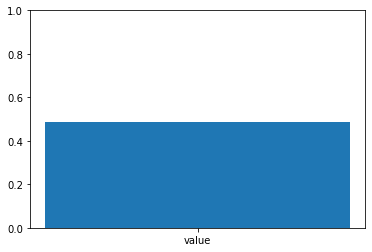

In [34]:
path_img = test_img()
print(learn.predict(path_img))
path_img